# Stockouts vs Delivery interval

Simulating the effect of increasing lot size (thereby reducing the number of annual deliveries) on a supply chain.  I will model typical numbers from each of my supply chain categories.  The code should be flexible enough that I could take any material as an input and estimate the effect

In [488]:
#loading packages
import math
import statistics
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()


In [489]:
# Defining global variables

#number of months in the simulation.  
#132 is chosen to allow for 1 year for the simulation to develop, and 10 years for measuring stockouts
sim_length = 132 

#service level for the base stock policy.
#3 is chosen based off previous Monte Carlo modeling and the desire to achieve 98% service level at Bell
service_level = 3

In [490]:
#calculating three month moving average from a dictionary of previous inventory levels given a reference month
def three_month_average(level, month):
    three_months = []
    if (len(level) > 3) and (month > 3):
        for i in range(1,4):
            three_months.append(level[month-i])
    elif len(level) <= 3:
        three_months = list(level.values())
    else:
        for i in range(0, month):
            three_months.append(level[month-i])
    average = np.mean(three_months)
    return(average)


level = {
    0:5,
    1:10,
    2:15,
    3:20,
    4:25,
    5:30,
    6:35,
    7:40,
    8:45,
    9:50,
    10:55,
    11:60,
    12:65,
    13:70,
}

#three_month_average(level, 6)

In [491]:
#calculating twelve month moving average from a dictionary of previous inventory levels given a reference month
def twelve_month_average(level, month):
    twelve_months = []
    if (len(level) > 12) and (month > 12):
        for i in range(1,13):
            twelve_months.append(level[month-i])
    elif len(level) <= 12:
        twelve_months = list(level.values())
    elif month == 1:
        twelve_months = level[1]
    else:
        for i in range(0, month):
            twelve_months.append(level[month-i])
    average = np.mean(twelve_months)
    return(average)

In [492]:
#calculating 12 month moving STDEV from a dictionary of previous inventory levels given a reference month
def twelve_month_stdev(level, month):
    twelve_months = []
    if (len(level) > 12) and (month > 12):
        for i in range(1,13):
            twelve_months.append(level[month-i])
            stdev = np.std(twelve_months, ddof=1)
    elif len(level) <= 12:
        twelve_months = list(level.values())
        stdev = np.std(twelve_months, ddof=1)
    elif month == 1:
        stdev = level[1]
    else:
        for i in range(0, month):
            twelve_months.append(level[month-i])
            stdev = np.std(twelve_months, ddof=1)
    return(stdev)


In [493]:
#A function that simulates demand, evaluates inventory changes during a month, and places an order if necessary
#level, demand, and orders are dictionaries with a month as the key and values specifing inventory parameters
#month is an integer, specifying the number of months since the start of the simulation
#lead time is an integer, specified in months
#min_lot is an integer specifying the minimum lot size

def evaluate_month(level, demand, orders, month):
    #calculating the change in inventory due to deliveries and consumption
    current_level = level[month] - demand[month] + orders[month]
    return(current_level)

    

In [494]:
#A function that generates an order based off demand and current level
def place_orders(level, target, min_lot):

    #placing an order if necessary
    if level < target:
        if (target - level) > (1.0 * min_lot):
            if (target - level) > min_lot:
                order = target - level
            else:
                order = min_lot
        else:
            order = 0
    else:
        order = 0
    return(order)
            
    
    

In [495]:
#A function that determines base stock policy inventory target
def base_stock(demand, month, frequency, lead_time, min_lot):
    mu = three_month_average(demand, month)
    sigma = twelve_month_stdev(demand, month)
    
    cycle_stock = mu * frequency / 3 #base stock formula for cycle stock
    
    safety_stock = sigma * service_level * 4 #math.sqrt(1 + lead_time) #base stock formula for safety stock

    
    target_stock = int(safety_stock + cycle_stock)
    return(target_stock)



In [496]:
#A function that simulates demand for a period specified by the global variables.  
#Restricts demand to being positive
def generate_demand(mean, sd):
    demand = {}
    for i in range(0, sim_length):
        consumption = int(np.random.normal(mean, sd))
        if consumption > 0:
            demand[i+1] = consumption
        else:
            demand[i+1] = 0
    return(demand)

In [497]:
#initializes a dictionary of orders to 0 so that follow on functions work if no orders are present
def initialize_orders():
    orders = {}
    for i in range(0, sim_length+12):
        orders[i] = 0 
    return(orders)

In [498]:
def run_scenario(mean, sd, frequency, lead_time, min_lot): 
    #initializing demand
    demand = generate_demand(mean, sd)
    
    #initializing the level at a reasonably high starting point to simulate current conditions
    level = {}
    level[1]= 6 * mean
    
    #initializing orders
    orders = initialize_orders()
    
    #calculating the change for each month and the need for an order
    for i in range(1, sim_length):
        ending_level = evaluate_month(level, demand, orders, i) #determines the level after consumption and arrivals
        level[i+1] =  ending_level # sets the next month starting level 
        
        #count the orders arriving between current month and lead time
        on_order = 0
        for month in range(i+1, i+lead_time):
            on_order += orders[month]
        
        #estimates the level when an order placed this month arrives
        lead_time_level = ending_level - three_month_average(demand, i) * lead_time + on_order
        target_level = base_stock(demand, i, frequency, lead_time, min_lot)
        
        #place an order to arrive at lead time
        orders[i+lead_time] = place_orders(lead_time_level, target_level, min_lot)
    
    #counting stockouts and determining average level
    #excludes values from first year to allow level to stabilize according to base stock policy
    stockouts = 0
    average_level = []
    
    for key, value in level.items():
        if (key > 11) and (key <= sim_length):
            if value <= 0:
                stockouts += 1
            average_level.append(value)
    
    return(stockouts, np.mean(average_level))
    
        
        


In [499]:
run_scenario(100, 100, 1, 5, 500)

(0, 1005.2782369146006)

In [500]:
#run the scenario an aribrary number of times.  Store the number of stockouts for each scenario in a list
def run_monte_carlo(mean, sd, frequency, lead_time, min_lot, iterations):
    stockouts = []
    level = []
    for i in range(0, iterations):
        scenario = run_scenario(mean, sd, frequency, lead_time, min_lot)
        stockouts.append(scenario[0])
        level.append(scenario[1])
    
    return(stockouts, level)

print(run_monte_carlo(10,10,1,5,10,10))

([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [117.39393939393939, 113.60881542699727, 130.06336088154274, 109.82920110192836, 130.48760330578511, 132.91735537190084, 110.11019283746558, 138.4462809917355, 136.91735537190084, 117.87052341597796])


In [501]:
#a function to quantify the percent of months in a simulated time period of length (sim_length) that were stocked out
#this gives the likelihood of a stockout in any given month for these particular conditions
def percent_stockout_months(results):   
    percentage = statistics.mean(results) / (sim_length-12)
    return(percentage)

test = run_monte_carlo(10,10,1,5,10,10)[0]
print(test)
print(statistics.mean(test))
print(percent_stockout_months(test))

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
0.1
0.0008333333333333334


In [502]:
#A function that ties it all together to create a series of stockout percentage and inventory level vs min lot size
def stockouts_vs_min_lot(mean, sd, lead_time, min_lot, iterations):

    percent_stockouts = []
    average_level = []
    x_axis = []

    #iterating over lot size as a function of average monthly demand
    for i in range (1, 13):
        min_lot1 = i * min_lot
        x_axis.append(i)
        
        #generating a monte carlo scenario
        scenario = run_monte_carlo(mean, sd, i, lead_time, min_lot1, iterations)
        
        #quantifying stockouts and average level
        percent_stockouts.append(percent_stockout_months(scenario[0]))
        average_level.append((np.mean(scenario[1])) / mean) #converts average inventory level to months of inventory
        

    
    return(x_axis, percent_stockouts, average_level)




In [503]:
#use the following parameters for an experiment
mean_exp = 100
sd_exp = 60
lead_time_exp = 5
min_lot_exp_1 = 300
min_lot_exp_2 = 100
min_lot_exp_3 = 150
iterations_exp = 1000



[0.0007,
 0.0016250000000000001,
 0.0025499999999999997,
 0.004775,
 0.008424999999999998,
 0.013216666666666666,
 0.019391666666666665,
 0.028025,
 0.03815,
 0.05059166666666667,
 0.061649999999999996,
 0.07459166666666667]

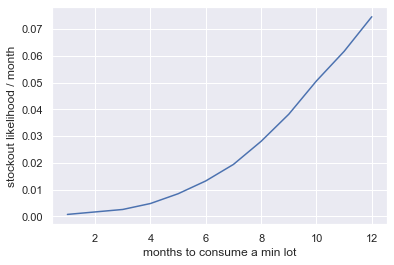

In [504]:
data = stockouts_vs_min_lot(mean_exp, sd_exp, lead_time_exp, min_lot_exp_2, iterations_exp)


[0.0007,
 0.0016250000000000001,
 0.0025499999999999997,
 0.004775,
 0.008424999999999998,
 0.013216666666666666,
 0.019391666666666665,
 0.028025,
 0.03815,
 0.05059166666666667,
 0.061649999999999996,
 0.07459166666666667]

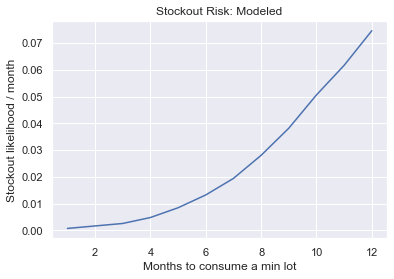

In [508]:
plt.plot(data[0], data[1])
plt.title('Stockout Risk: Modeled')
plt.ylabel('Stockout likelihood / month')
plt.xlabel('Months to consume a min lot')
plt.savefig('5_month_risk_2.jpg')
data[1]

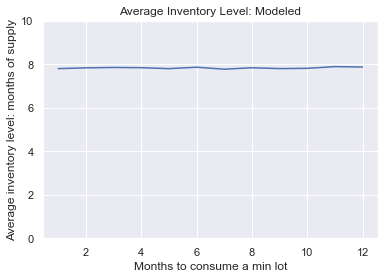

In [509]:
plt.plot(data[0], data[2])
plt.title('Average Inventory Level: Modeled')
plt.ylabel('Average inventory level: months of supply')
plt.xlabel('Months to consume a min lot')
plt.ylim(0,10)
plt.savefig('5_month_inventory_2.jpg')

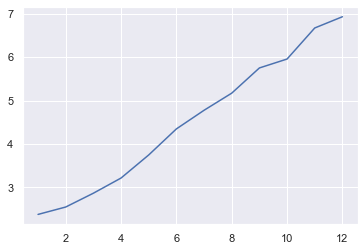

In [410]:
#scaling for relative amount of inventory
scaled = [i / j * 100 for i, j in zip(data[1], data[2])] 
scaled
plt.plot(data[0], scaled)

In [411]:
#setting up a pandas DF so that I can keep all my experiments in a single place, and then access them for graphing
columns = ['mean', 'stdev', 'cv', 'lead_time', 'min_lot', 'iterations', 'month', 'stockout_percentage',
          'inventory_level']

df = pd.DataFrame(columns=columns)

In [412]:
#Filling the df, varying cv (stdev) and lead_time
mean1 = 100
stdev_options = [50, 100, 150, 200, 300, 500]
lead_time_options = [1, 5, 12]
min_lot1 = 100
iterations1 = 1000

for i in stdev_options:
    for j in lead_time_options:
        results = [mean1, i, i/mean1, j, min_lot1, iterations1]
        data = stockouts_vs_min_lot(mean1, i, j, min_lot1, iterations1)
        
        for index, month in enumerate(data[0]):
            df.loc[len(df)] = [mean1, i, i/mean1, j, min_lot1, iterations1, month, data[1][index], data[2][index]]
            



In [413]:
df

,mean,stdev,cv,lead_time,min_lot,iterations,month,stockout_percentage,inventory_level
0,100.0,50.0,0.5,1.0,100.0,1000.0,1.0,0.028783,1.470064
1,100.0,50.0,0.5,1.0,100.0,1000.0,2.0,0.127283,1.214172
2,100.0,50.0,0.5,1.0,100.0,1000.0,3.0,0.242667,0.996025
3,100.0,50.0,0.5,1.0,100.0,1000.0,4.0,0.339600,0.765507
4,100.0,50.0,0.5,1.0,100.0,1000.0,5.0,0.405717,0.547533
...,...,...,...,...,...,...,...,...,...
211,100.0,500.0,5.0,12.0,100.0,1000.0,8.0,0.046850,49.993255
212,100.0,500.0,5.0,12.0,100.0,1000.0,9.0,0.047517,50.215514
213,100.0,500.0,5.0,12.0,100.0,1000.0,10.0,0.047050,51.626292
214,100.0,500.0,5.0,12.0,100.0,1000.0,11.0,0.044300,53.442798


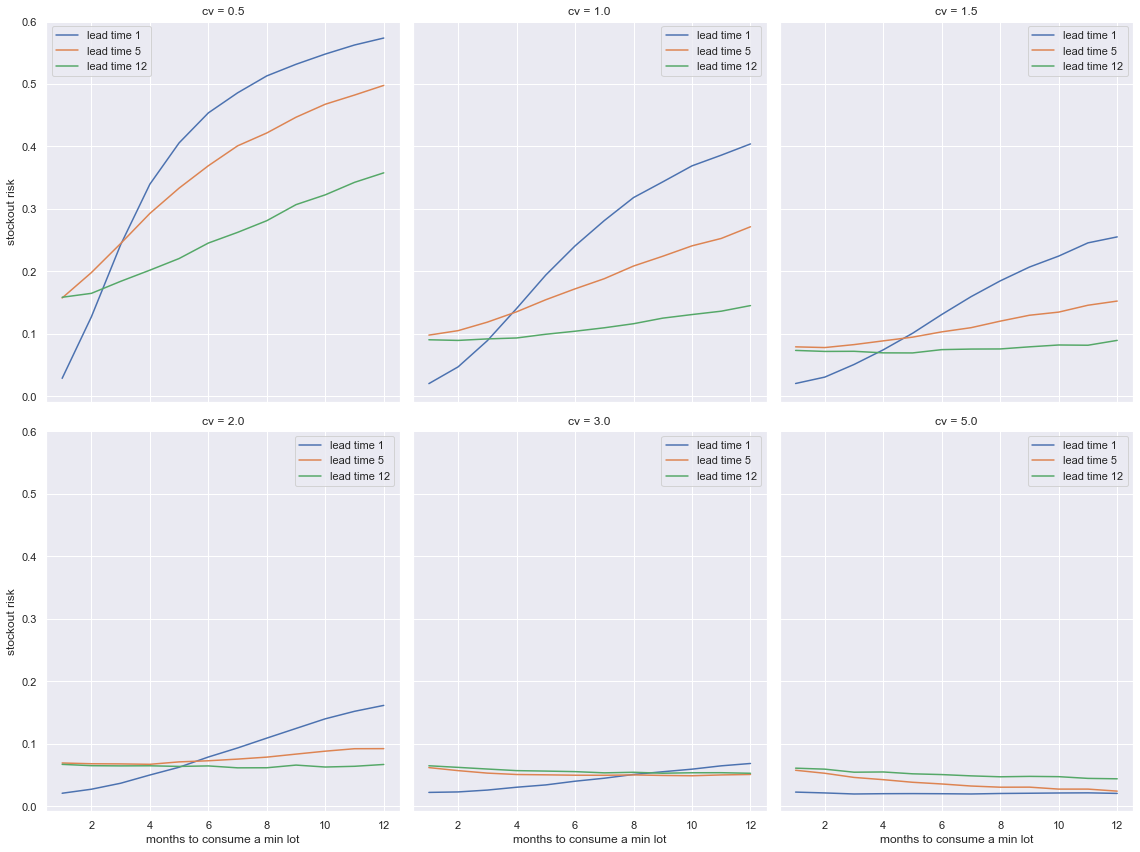

In [414]:
#plotting in small multiples.  Each graph will have a common cv, but show the effects of changing lead time
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(16,12))

#making a flat list out of the list of list of subplots
axes_list = [item for sublist in axes for item in sublist] 

#creating a graph of small multiples.  Each subplot features a different CV and shows the different lead time risks
for index, axis in enumerate(axes_list):
    
    for i in lead_time_options:
        df[(df['lead_time'] == i) & (df['cv'] == (stdev_options[index]/100))].plot(x='month', 
                                                                                   y='stockout_percentage', 
                                                                                   ax=axis, 
                                                                                   label=('lead time ' + str(i)))
        axis.set_title("cv = " + str(stdev_options[index]/100))
        axis.set_xlabel('months to consume a min lot')
        axis.set_ylabel('stockout risk')



# If you don't do tight_layout() you'll have weird overlaps
plt.savefig('stockout_risk_multiples.jpg')
plt.tight_layout()

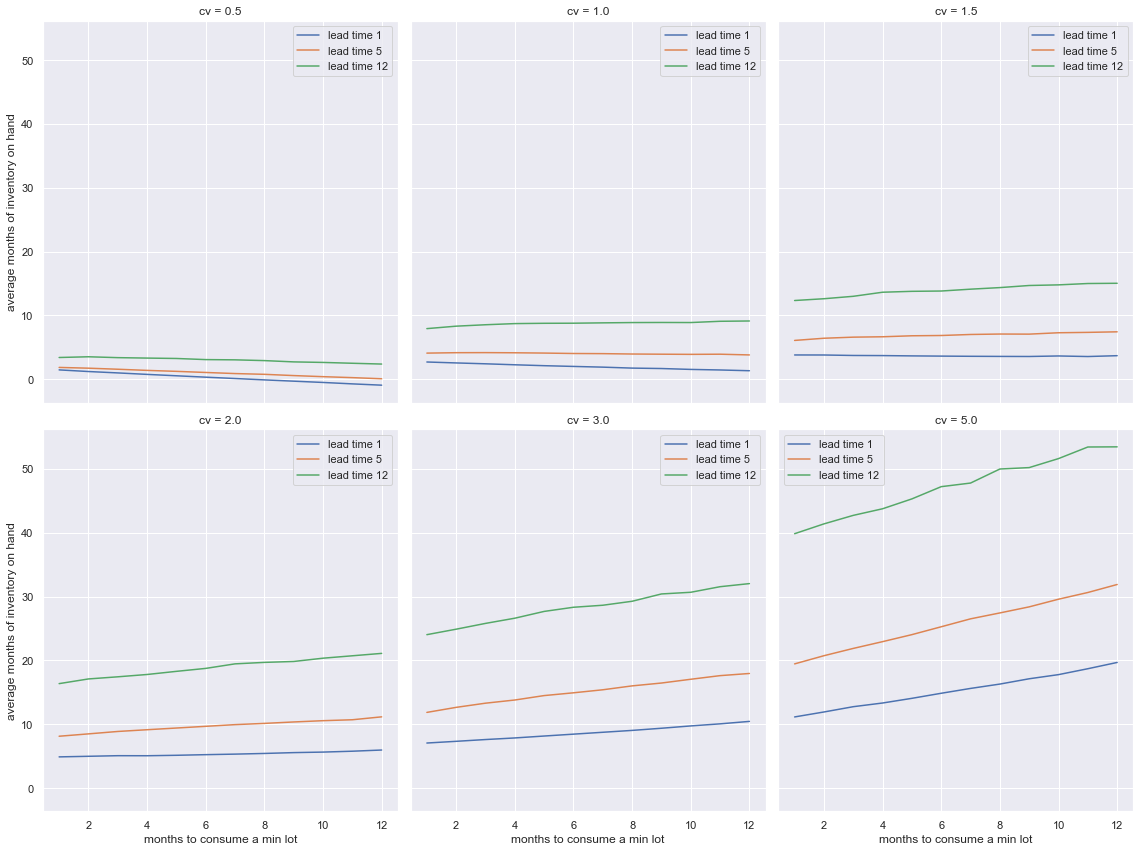

In [415]:
#confirming average inventory levels stay the same in each scenario
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(16,12))

#making a flat list out of the list of list of subplots
axes_list = [item for sublist in axes for item in sublist] 

for index, axis in enumerate(axes_list):
    
    for i in lead_time_options:
        df[(df['lead_time'] == i) & (df['cv'] == (stdev_options[index]/100))].plot(x='month', 
                                                                                   y='inventory_level', 
                                                                                   ax=axis, 
                                                                                   label=('lead time ' + str(i)))
        axis.set_title("cv = " + str(stdev_options[index]/100))
        axis.set_xlabel('months to consume a min lot')
        axis.set_ylabel('average months of inventory on hand')



# If you don't do tight_layout() you'll have weird overlaps
plt.savefig('inventory_level_multiples.jpg')
plt.tight_layout()

In [515]:
#importing actual data from excel so graphs look the same
actuals = pd.read_excel('Min lot impact actuals.xlsx', sheet_name='raw', header=1, usecols='AV:AZ', nrows=5)
actuals

,Time to consume min lot,CV,Stockout Risk: Medium Use Materials,Ave. Inventory Level,Number of materials
0,1,NaN,NaN,NaN,NaN
1,2,0.522375,0.015674,8.436149,11.0
2,3,0.614450,0.009579,9.051331,18.0
3,4,0.624768,0.021552,7.182091,8.0
4,5,0.698454,0.008621,7.992092,4.0


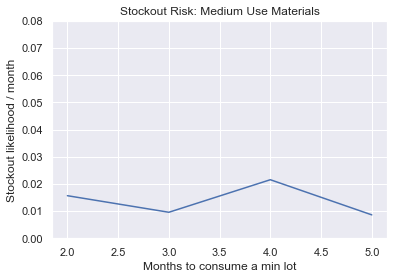

In [520]:
#plotting the actual risk levels
plt.plot(actuals['Time to consume min lot'], actuals['Stockout Risk: Medium Use Materials'])
plt.title('Stockout Risk: Medium Use Materials')
plt.ylabel('Stockout likelihood / month')
plt.xlabel('Months to consume a min lot')
plt.ylim(0,0.08)
plt.savefig('5_month_risk_actuals.jpg')


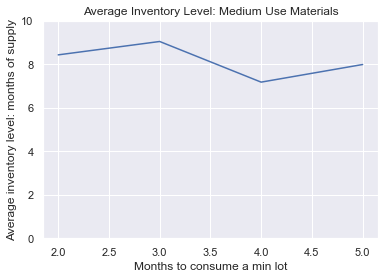

In [521]:
#plotting the actual inventory levels
plt.plot(actuals['Time to consume min lot'], actuals['Ave. Inventory Level'])
plt.title('Average Inventory Level: Medium Use Materials')
plt.ylabel('Average inventory level: months of supply')
plt.xlabel('Months to consume a min lot')
plt.ylim(0,10)
plt.savefig('5_month_inventory_actuals.jpg')